Last Update: 2022.05.04

Changes: updating workdir_path to my my drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
workdir_path = '/content/drive/MyDrive/BI-Master/RN-segmentacao_semantica_de_imagens'  #segmentacao_semantica_de_imagens'

os.chdir(workdir_path)

# DATA PREPROCESSING:

In [ ]:
'''
dataset: 

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

'''

'\ndataset: \n\nhttps://www.kaggle.com/dansbecker/cityscapes-image-pairs\n\n'

## IMPORT ALL LIBRARIES:

In [ ]:
!pip install scikit-learn==0.22.1

     |████████████████████████████████| 7.0 MB 4.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd 
import os
import cv2
from glob import glob
import pickle

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,UpSampling2D

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate, add

In [ ]:
!ls

cityscapes_data  image_segmentation.ipynb  kmeans.pkl  segnet.png


Listing of all train and test images:

In [ ]:
train_list = glob('cityscapes_data/train/*')
test_list = glob('cityscapes_data/val/*')

In [ ]:
train_list[:10]

['cityscapes_data/train/443.jpg',
 'cityscapes_data/train/479.jpg',
 'cityscapes_data/train/451.jpg',
 'cityscapes_data/train/459.jpg',
 'cityscapes_data/train/457.jpg',
 'cityscapes_data/train/86.jpg',
 'cityscapes_data/train/95.jpg',
 'cityscapes_data/train/460.jpg',
 'cityscapes_data/train/461.jpg',
 'cityscapes_data/train/458.jpg']

In [ ]:
len(train_list)
len(test_list)


183

## Load image:

In [ ]:
img=cv2.imread(train_list[13])

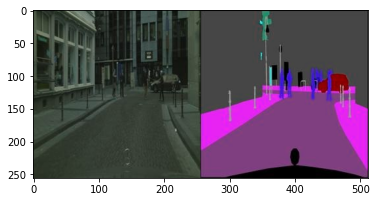

In [ ]:
plt.imshow(img)

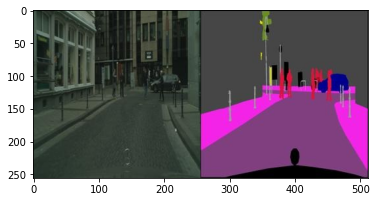

In [ ]:
img=cv2.imread(train_list[13])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )   # open cv trabalha com RGB
plt.imshow(img)

In [ ]:
def load_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X=img[:,:256,:]
    Y=img[:,256:,:]
    return X,Y

## ASSIGN CLASS LABELS USING KMEANS FOR SEGMENTED IMAGES:

In [ ]:
from tqdm import tqdm
colors=[]

for i in tqdm(range(200)):
    x,y=load_image(train_list[i])
    colors.append(y.reshape(y.shape[0]*y.shape[1],3))

100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


In [ ]:
colors

In [ ]:
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))
print(colors.shape)

(13107200, 3)


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=13, random_state=0)
kmeans.fit(colors)
pickle.dump(kmeans, open("kmeans.pkl", "wb"))
kmeans = pickle.load(open("kmeans.pkl", "rb"))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
kmeans.cluster_centers_

array([[128.06582726,  63.08828074, 127.41125338],
       [118.24263906, 131.9071176 ,  91.75298895],
       [236.96665236,  39.62624712, 225.23923955],
       [  5.47824321,   4.21365878,   7.11889082],
       [106.72784262, 140.19320264,  35.8571727 ],
       [  3.55442405,   3.43893509, 136.47393139],
       [198.42863536, 156.53498381, 159.72123372],
       [ 79.7590489 ,   6.73232124,  71.14679312],
       [ 77.17802915, 125.57890677, 171.59699778],
       [ 69.88216743,  70.29280808,  68.90519102],
       [215.10022293, 199.48634381,  41.30648139],
       [158.56822039, 245.37947967, 156.0605142 ],
       [200.94687416,  26.56961923,  58.8310559 ]])

In [ ]:
def mask_to_labels(mask):
    masked=mask.reshape((mask.shape[0]*mask.shape[1],3))
    pred=kmeans.predict(masked)
    pred=pred.reshape(mask.shape[0],mask.shape[1])

    cls = np.zeros((mask.shape[0], mask.shape[1], 13))
    # cls é a classe, com 13 de dimensao, que é cada cor
    
    for i in range(13):
        cls[:, :, i] = (pred == i ).astype(int)
        

    return cls  

## LOADING DATA FOR TRAINING USING DATA GENERATOR:

In [ ]:
# carega 10 imagens, sempre que é acionado
def data_generator(path, batch_size=10):
    while True:
        for i in range(0, len(path), batch_size):
            batch_files = path[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = load_image(file)
                

                imgs.append(image)
                segs.append(mask_to_labels(mask))

            yield np.array(imgs), np.array(segs)

In [ ]:
train_gen=data_generator(train_list)
valid_gen=data_generator(test_list)

# SEGNET MODEL ARCHITECTURE:

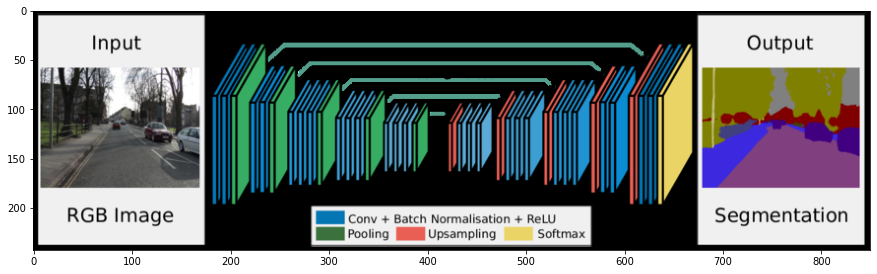

In [ ]:
def load_img(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
image=load_img('segnet.png')
fig, axs = plt.subplots(figsize=(15,40))
axs.imshow(image)

In [ ]:
####### SEGNET ######
def segnet():
    
    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2) 
    
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3) 
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4) 
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5) 
    

    
    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    
    
    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3) 

    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3) 

    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    output=Conv2D(13,(1,1),activation='softmax')(batch2)
    ## MUDANDO A SAIDA PARA 13 DIM
    # NAO TEM A CAMADA DENSE
    
    model=Model(input1,output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=len(kmeans.cluster_centers_))])
    return model

In [ ]:
segnet_model=segnet()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
segnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 256, 256, 64  256        ['conv2d_32[0][0]']              
 ormalization)                  )                                                           

# TRAINING SEGNET MODEL:

In [ ]:
segnet_model.fit_generator(train_gen,steps_per_epoch=len(train_list) // 10,
        epochs=2,
        validation_data=valid_gen,
        validation_steps=len(test_list)//10)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


50/50 [==============================] - 131s 3s/step - loss: 1.7050 - accuracy: 0.5171 - mean_io_u_1: 0.4615 - val_loss: 26.2924 - val_accuracy: 0.1444 - val_mean_io_u_1: 0.4938
Epoch 2/2
50/50 [==============================] - 125s 2s/step - loss: 0.9987 - accuracy: 0.7319 - mean_io_u_1: 0.4615 - val_loss: 5.8836 - val_accuracy: 0.3687 - val_mean_io_u_1: 0.4826


## CONVERT PREDICTED CLASSES OUTPUT INTO IMAGE:

In [ ]:
def classes_to_colors(pred):
    pred=np.array(pred).reshape((256,256,13))
    pred=np.argmax(pred,axis=2)

    mask=np.zeros((256,256,3))
    for i in range(13):
        ind=np.where(pred==i)
        mask[ind[0],ind[1],:]=kmeans.cluster_centers_[i]
    return mask
        

# SAVE AND LOAD MODEL

In [ ]:
segnet_model.save('segnet_model.h5')

In [ ]:
segnet_model=tf.keras.models.load_model('segnet_model.h5')

# PREDICTION:

In [ ]:
print('select three images for prediction between 0 and '+str(len(test_list)))
img=[]
mask=[]
k = [5, 6, 7]
for i in range(3):
    #k=input('select image number from test list:')
    im,m=load_image(test_list[int(k[i])])
    img.append(im)   # UM VERTOR DE IMAGENS
    mask.append(m)   # UM VETOR DE MASCARAS
    

select three images for prediction between 0 and 183


In [ ]:
pred=[]
for i in range(3):
    p=segnet_model([img[i].reshape(1,256,256,3)])   ##### ISSO É O PREDICT
    p=classes_to_colors(p)
    p=p.astype(int)
    pred.append(p)

# PLOTTING PREDICTED OUTPUTS USING SEGNET MODEL:

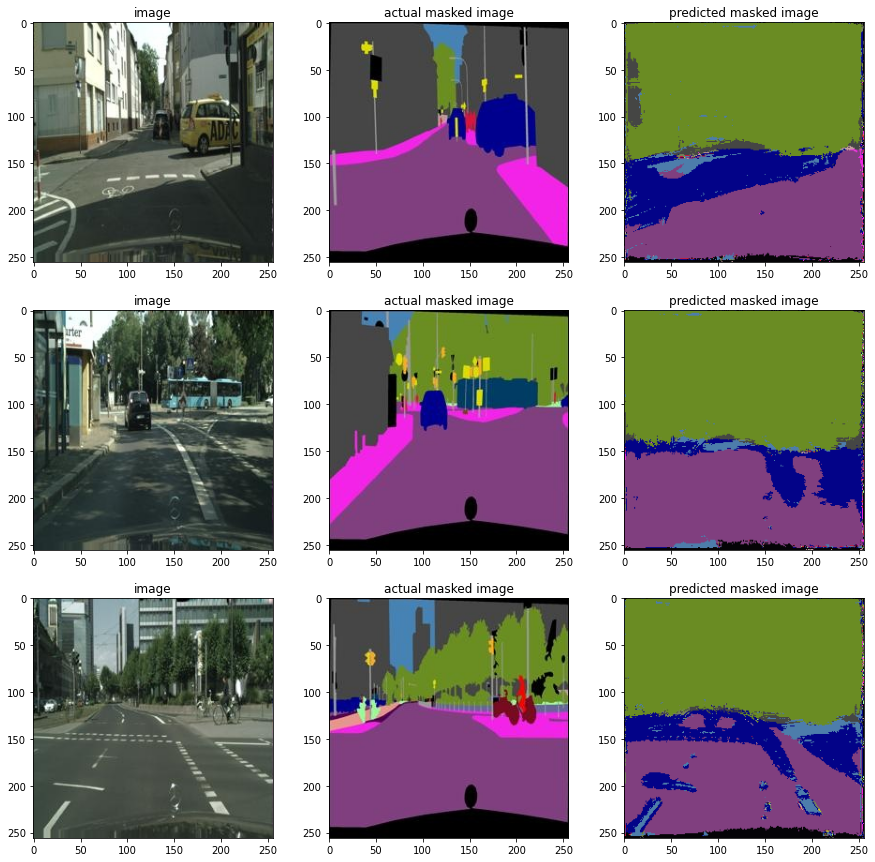

In [ ]:
fig, axs = plt.subplots(3, 3,figsize=(15,15))

for i in range(3):
    axs[i][0].set_title('image')
    axs[i][0].imshow(img[i])
    axs[i][1].set_title('actual masked image')
    axs[i][1].imshow(mask[i])
    axs[i][2].set_title('predicted masked image')
    axs[i][2].imshow(pred[i])
plt.show()